In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import numpy as np
import datetime

In [2]:
# Parse data
def parseData(filename):

    quake_cat = pd.read_csv(filename, parse_dates=[3, 4])

    pd.set_option('display.max_columns', None)  # Allow all of the DataFrame to be printed

    # Sort data by publicid, then by modification time

    quake_cat = quake_cat.sort_values(by=['publicid','modificationtime'])

    # Change negative longitudes to positive
    
    quake_cat.loc[quake_cat.longitude < 0, 'longitude'] += 360

    return quake_cat

In [3]:
# Trim data by time
def trimDataByTime(data, start_time, end_time):

    data['time'] = pd.to_datetime(data['time']) # convert times to datetime64 objects
    data = data.loc[((data['time'] >= pd.to_datetime(start_time)) &
                               (data['time'] <= pd.to_datetime(end_time)))]
    
    return data

In [4]:
# Returns 3 dataframes: Manually reviewed, Manual reviewed with current magnitude, and Automatically reviewed.
def returnDataFrames(data):

    # Find the first manually reviewed origin for each eventid, if one exists

    manual = data.loc[((data['evaluationmode'] == 'manual') | (data['evaluationstatus'] == 'preliminary')) & ((data['type'] == 'earthquake') | (data['type'] == 'outside of network interest'))]
    manual = manual.sort_values(by=['modificationtime'])


    # Find events which are not currently deleted.
    exist = manual.groupby('publicid').nth(-1).reset_index()
    exist = exist.loc[(exist['type'] == 'earthquake') | (exist['type'] == 'outside of network interest') | (exist['type'] == '')]


    # Finding manual events continued.
    manualMag = manual.groupby('publicid').nth(-1).reset_index()
    manual = manual.groupby('publicid').nth(0).reset_index()


    # Find those events with both a manual and automatic origin, then find the first automatic origin for such events

    automatic = data.loc[(data['evaluationmode'] == 'automatic')]
    automatic = automatic.loc[automatic['publicid'].isin(manual.publicid)]
    automatic = automatic.sort_values(by=['modificationtime'])
    automatic = automatic.groupby('publicid').nth(0).reset_index()


    # Filter the first manual origins of events such that only those with a corresponding automatic origin are kept

    manualMag = manualMag.loc[manualMag['publicid'].isin(automatic.publicid)]
    manual = manual.loc[manual['publicid'].isin(automatic.publicid)]


    # Filter out events that are currently deleted.

    manualMag = manualMag.loc[manualMag['publicid'].isin(exist.publicid)]
    manual = manual.loc[manual['publicid'].isin(exist.publicid)]
    automatic = automatic.loc[automatic['publicid'].isin(exist.publicid)]


    # Reset the index for the manual dataframe after matching against automatic events, then remove the old index
    manual = manual.reset_index()
    manual = manual.drop('index', 1)

    # Reset the index for the manualMag dataframe after matching against automatic events, then remove the old index
    manualMag = manualMag.reset_index()
    manualMag = manualMag.drop('index', 1)

    # Reset the index for the automatic dataframe after matching against exsiting events, then remove the old index
    automatic = automatic.reset_index()
    automatic = automatic.drop('index', 1)
    
    return manual,manualMag,automatic

The Review Time (RT) of an event is calculated as the difference between the first automatic origin ($AT^{1}$) and the first manual origin ($MT^{1}$). This assumes that the first automatic origin is coincident with the "earthquake occurence in New Zealand".

$RT = AT^{1} - MT^{1}$

In [6]:
# Returns final dataframe to be used for analysis.
def returnAnalysisDataFrame(manual, manualMag, automatic):

    # Convert times to datetime objects

    manual['modificationtime'] = pd.to_datetime(manual['modificationtime']).dt.tz_convert('UTC')
    automatic['modificationtime'] = pd.to_datetime(automatic['modificationtime']).dt.tz_convert('UTC')

    # Calculate review times

    RT =  pd.DataFrame((manual['modificationtime'] - automatic['modificationtime']))
    RT.columns = ['delta']

    # Calculate review time in minutes for analysis

    RT['minutes'] = (RT['delta'].dt.total_seconds()) / 60

    # Add other columns from the manual origin for use in analysis

    RT['OT'] = manual['time']
    RT['MT'] = manual['modificationtime']
    RT['MT_NZT'] = manual['modificationtime'].dt.tz_convert('NZ')
    RT['magnitude'] = manualMag['magnitude']
    RT['latitude'] = manual['latitude']
    RT['longitude'] = manual['longitude']
    RT['publicid'] = manual['publicid']


    # Add columns for use in data splitting: magnitude (rounded to nearest unit)

    ### Floor magnitude to integer
    RT['int_magnitude'] = RT['magnitude'].astype(int)

    return RT

In [7]:
# Define a function for calculating a distribution
def calculate_distribution(data_list, round_to):
    """
    Calculate the distribution of a list of floats, where floats are rounded to the nearest round_to value.
    :param data_list: list of data values
    :param round_to: value to round data to for distribution calculation, e.g. 0.1 rounds data to the nearest 0.1
    :return: data values in distribution for which data exists, number of data > 0 at each data value
    """
    
    # First, prepare data for distribution calculation ("rounding") and remove nan values (nn = non-nan)
    
    nn_rounded_data_list = []
    for i in range(len(data_list)):
        try:
            if round_to <= 1:
                # Here "inflate" decimal data to integers to make distribution calculation easier
                nn_rounded_data_list.append(int(round((1 / round_to) * data_list[i])))
            else:
                # Here simply round the data to the nearest value
                nn_rounded_data_list.append(int(round(data_list[i] / round_to)))
        except:  # Fails on nan values
            pass

    # Prepare distribution lists
        
    data_counts = [0] * int(max(nn_rounded_data_list) + 1)
    data_values = list(range(max(nn_rounded_data_list) + 1))

    # Calculate distribution
    
    for i in data_values:
        if nn_rounded_data_list.count(i) > 0:
            data_counts[i] = nn_rounded_data_list.count(i)

    # If rounding to a decimal, convert data values to decimal values
            
    if round_to <= 1:
        for i in range(len(data_values)):
            data_values[i] /= (1 / round_to)
            
    # For later analytical efficiency, remove points with 0 values in distribution

    DVNZ = []  # data values non zero
    DCNZ = []  # data counts non zero
    for n in range(len(data_counts)):
        if data_counts[n] > 0:
            DVNZ.append(data_values[n])
            DCNZ.append(data_counts[n])

    return DVNZ, DCNZ

In [8]:
# Plot the data distribution(s)
def plot(RT, filter_window, filter_box, start_time, end_time, by_magnitude, rounding_value,
         time_window, window_overlap, doPlot, doPrint):

    # Set the colours to use in plotting from the shift sequence colours (assuming max subsets for plotting = 9!)
    colours = ['black','red','green','purple','yellow','blue','orange', 'pink', 'magenta', 'cyan']

    # Apply temporal filtering

    if filter_window:
        print('Filtering review times to those between limits: [' + str(filter_window[0]) + ' - ' + 
              str(filter_window[1]) + '] minutes')
        print('Number of values before filtering is: ' + str(len(RT['minutes'].values)))
        if filter_window[0] and filter_window[1]:
            analysis_data = RT.loc[(RT['minutes'] >= filter_window[0]) & (RT['minutes'] <= filter_window[1])]
        elif filter_window[0] and not filter_window[1]:
            analysis_data = RT.loc[(RT['minutes'] >= filter_window[0])]
        elif filter_window[1] and not filter_window[0]:
            analysis_data = RT.loc[(RT['minutes'] <= filter_window[1])]
        elif not filter_window[0] and not filter_window[1]:
            analysis_data = RT
        #print('Number of values remaining after filtering is: ' + str(len(analysis_data['minutes'].values)))
    else:
        print('No data filtering has been performed.')
        analysis_data = RT


    # Apply spatial filtering

    if filter_box:
        print('Filtering earthquakes to those in the box between latitudes '
             + str(filter_box[0]) + ' and ' + str(filter_box[1]) + ' and longitudes ' + str(filter_box[2])
             + ' and ' + str(filter_box[3]))
        analysis_data = analysis_data.loc[((analysis_data['latitude'] >= filter_box[0]) &
                                         (analysis_data['latitude'] <= filter_box[1]) &
                                         (analysis_data['longitude'] >= filter_box[2]) &
                                         (analysis_data['longitude'] <= filter_box[3]))]
    else:
        print('No spatial filtering has been performed.')
        print('Number of values remaining after boundary filtering is: ' + str(len(analysis_data['minutes'].values)))


    # Set up splitting factors

    if by_magnitude == True:
        print('Splitting data by magnitude...')
        splitting_column = 'int_magnitude'
        splitting_factors = ['all', 1, 2, 3, 4, 5, 6, 7, 8]
    else:
        print('No data splitting will be performed.')
        splitting_factors = ['all']

    # Apply any factor fixing to the data

    if by_magnitude and by_magnitude != True:
        print('Subsetting data to that with integer magnitude == ' + str(by_magnitude) + ' ...')
        analysis_data = analysis_data.loc[(analysis_data['int_magnitude'] == by_magnitude)]

    # Initiate time windowing of data

    if time_window:
        print('Binning data by time windows...')
        window_start = min(analysis_data['OT'].values)
        window_end = window_start + np.timedelta64(time_window, 's')
    else:
        print('No data time binning has been performed.')
        time_window = 1  # This will break the while loop following the first while loop iteration
        window_overlap = 0
        window_start = min(analysis_data['OT'].values)
        window_end = max(analysis_data['OT'].values)

    # Run the data analysis to generate the distribution(s)

    print('Calculating distribution(s)...')

    analytics_data_types = ['data_values', 'data_counts', 'median', '95_perc', 'start_time', 'end_time', 'split_idx']
    analytics_data = [[] for i in range(len(analytics_data_types))]

    last_data = max(analysis_data['OT'].values)
    
    while window_end <= last_data:

        # Gather data for current time window

        current_window_data = analysis_data.loc[(analysis_data['OT'].values >= window_start) & 
                                               (analysis_data['OT'].values <= window_end)]        

        # Apply data splitting

        for i in range(len(splitting_factors)):

            # Gather data for current split

            if splitting_factors[i] == 'all':  # Analyse all data in the time window first
                current_data = current_window_data
            else:
                current_data = current_window_data.loc[current_window_data[splitting_column] == splitting_factors[i]]

            # Calculate the data distribution

            data_list = list(current_data['minutes'].values)
            if len(data_list) > 0:
                data_values, data_counts = calculate_distribution(data_list, rounding_value)

                # Store the data for analysis

                analytics_data[0].append(data_values)
                analytics_data[1].append(data_counts)
                analytics_data[2].append((round(np.percentile(data_list, 50), 2)))
                analytics_data[3].append((round(np.percentile(data_list, 95), 2)))
                analytics_data[4].append(str(window_start)[:10])
                analytics_data[5].append(str(window_end)[:10])
                analytics_data[6].append(i)

        # Update time loop parameters

        window_start += np.timedelta64(round(time_window * (1 - window_overlap)), 's')  
        window_end += np.timedelta64(round(time_window * (1 - window_overlap)), 's')

    print('Start Time: ' + start_time)
    print('End Time: ' + end_time)

    if doPlot == True:
        
        # Plot the distributions
        
        print('Plotting distribution(s)...')
        print('-----------------------------------------------------------------------')

        # Plot the distribution(s)

        if len(analytics_data[0]) > 5:
            y_len = (12 * (len(analytics_data[0]) / 6))
        else:
            y_len = 12

        fig, ax = plt.subplots(figsize=(12, y_len))

        badges = []
        max_data_counts = []
        y_labels = []
        for i in range(len(analytics_data[0])):

            # Prepare y labels

            max_data_count = max(analytics_data[1][i])
            y_labels.append('start = ' + analytics_data[4][i] + 
                            '\nend = ' + analytics_data[5][i] + 
                            '\nmax = ' + str(max_data_count) + 
                            '\nN = ' + str(sum(analytics_data[1][i])) + 
                            '\nmedian = ' + str(analytics_data[2][i]) + 
                            '\n95% = ' + str(analytics_data[3][i]))

            # Normalise each distribution

            normalised_data_counts = []
            for j in range(len(analytics_data[0][i])):
                normalised_data_counts.append((analytics_data[1][i][j] / max_data_count) + i - 0.5)

            # Plot the medians and 95% values of each distribution

            plt.plot([analytics_data[2][i]] * 2, [min(normalised_data_counts), max(normalised_data_counts) - 0.1],
                     color='k', linestyle='--', linewidth=1)
            plt.plot([analytics_data[3][i]] * 2, [min(normalised_data_counts), max(normalised_data_counts) - 0.1],
                     color='k', linestyle='-.', linewidth=1)

            # Plot each distribution

            plt.plot(analytics_data[0][i], normalised_data_counts, color=colours[analytics_data[6][i]], linewidth=2)

            badges.append(patches.Patch(color=colours[analytics_data[6][i]]))

        # Add figure formatting

        ax.set_yticks(list(range(len(analytics_data[0]))))
        ax.set_yticklabels(y_labels)
        plt.locator_params(axis='x', nbins=10)
        plt.xlabel('review time value (scale 1:' + str(rounding_value) + ' minutes)', labelpad=15, fontsize=14)

        badges = badges[:len(splitting_factors)]
        badges.reverse()
        plt.legend(handles=badges, fontsize=14, framealpha=1, borderpad=1, labelspacing=0.75, handlelength=2,
                  columnspacing=1)

        plt.subplots_adjust(left=0.13, right=0.98, bottom=0.12, top=0.9)
        fig.suptitle('review time distribution with data rounded to nearest ' + str(rounding_value) + 
                     ' minutes', y=0.93, fontsize=14)

        # Show the plot!

        plt.savefig('distribution.png', format='png', dpi=300)
        plt.show()
        
    if doPrint == True:
        
        # Return the review time data in a csv-ready format
        
        print('\nstart time of time window, time window length, number of events, median event review time')
        for i in range(len(analytics_data[0])):
            print(str(analytics_data[4][i]) + ',' + str(time_window) + ',' + str(sum(analytics_data[1][i])) + ',' + str(analytics_data[2][i]))      

In [9]:
# Plot the data distribution(s)
def plot(RT, filter_window, filter_box, start_time, end_time, by_magnitude, rounding_value,
         time_window, window_overlap, doPlot, doPrint):

    # Set the colours to use in plotting from the shift sequence colours (assuming max subsets for plotting = 7!)
    colours = ['black','red','green','purple','yellow','blue','orange']

    # Apply temporal filtering

    if filter_window:
        print('Filtering review times to those between limits: [' + str(filter_window[0]) + ' - ' + 
              str(filter_window[1]) + '] minutes')
        print('Number of values before filtering is: ' + str(len(RT['minutes'].values)))
        if filter_window[0] and filter_window[1]:
            analysis_data = RT.loc[(RT['minutes'] >= filter_window[0]) & (RT['minutes'] <= filter_window[1])]
        elif filter_window[0] and not filter_window[1]:
            analysis_data = RT.loc[(RT['minutes'] >= filter_window[0])]
        elif filter_window[1] and not filter_window[0]:
            analysis_data = RT.loc[(RT['minutes'] <= filter_window[1])]
        elif not filter_window[0] and not filter_window[1]:
            analysis_data = RT
        #print('Number of values remaining after filtering is: ' + str(len(analysis_data['minutes'].values)))
    else:
        print('No data filtering has been performed.')
        analysis_data = RT


    # Apply spatial filtering

    if filter_box:
        print('Filtering earthquakes to those in the box between latitudes '
             + str(filter_box[0]) + ' and ' + str(filter_box[1]) + ' and longitudes ' + str(filter_box[2])
             + ' and ' + str(filter_box[3]))
        analysis_data = analysis_data.loc[((analysis_data['latitude'] >= filter_box[0]) &
                                         (analysis_data['latitude'] <= filter_box[1]) &
                                         (analysis_data['longitude'] >= filter_box[2]) &
                                         (analysis_data['longitude'] <= filter_box[3]))]
    else:
        print('No spatial filtering has been performed.')
        print('Number of values remaining after boundary filtering is: ' + str(len(analysis_data['minutes'].values)))


    # Set up splitting factors

    if by_magnitude == True:
        print('Splitting data by magnitude...')
        splitting_column = 'int_magnitude'
        splitting_factors = ['all', 1, 2, 3, 4, 5, 6]
    else:
        print('No data splitting will be performed.')
        splitting_factors = ['all']

    # Apply any factor fixing to the data

    if by_magnitude and by_magnitude != True:
        print('Subsetting data to that with integer magnitude == ' + str(by_magnitude) + ' ...')
        analysis_data = analysis_data.loc[(analysis_data['int_magnitude'] == by_magnitude)]

    # Initiate time windowing of data

    if time_window:
        print('Binning data by time windows...')
        window_start = min(analysis_data['OT'].values)
        window_end = window_start + np.timedelta64(time_window, 's')
    else:
        print('No data time binning has been performed.')
        time_window = 1  # This will break the while loop following the first while loop iteration
        window_overlap = 0
        window_start = min(analysis_data['OT'].values)
        window_end = max(analysis_data['OT'].values)

    # Run the data analysis to generate the distribution(s)

    print('Calculating distribution(s)...')

    analytics_data_types = ['data_values', 'data_counts', 'median', '95_perc', 'start_time', 'end_time', 'split_idx']
    analytics_data = [[] for i in range(len(analytics_data_types))]

    last_data = max(analysis_data['OT'].values)
    
    while window_end <= last_data:

        # Gather data for current time window

        current_window_data = analysis_data.loc[(analysis_data['OT'].values >= window_start) & 
                                               (analysis_data['OT'].values <= window_end)]        

        # Apply data splitting

        for i in range(len(splitting_factors)):

            # Gather data for current split

            if splitting_factors[i] == 'all':  # Analyse all data in the time window first
                current_data = current_window_data
            else:
                current_data = current_window_data.loc[current_window_data[splitting_column] == splitting_factors[i]]

            # Calculate the data distribution

            data_list = list(current_data['minutes'].values)
            if len(data_list) > 0:
                data_values, data_counts = calculate_distribution(data_list, rounding_value)

                # Store the data for analysis

                analytics_data[0].append(data_values)
                analytics_data[1].append(data_counts)
                analytics_data[2].append((round(np.percentile(data_list, 50), 2)))
                analytics_data[3].append((round(np.percentile(data_list, 95), 2)))
                analytics_data[4].append(str(window_start)[:10])
                analytics_data[5].append(str(window_end)[:10])
                analytics_data[6].append(i)

        # Update time loop parameters

        window_start += np.timedelta64(round(time_window * (1 - window_overlap)), 's')  
        window_end += np.timedelta64(round(time_window * (1 - window_overlap)), 's')

    print('Start Time: ' + start_time)
    print('End Time: ' + end_time)
    print('Boundary: MinLat: '
             + str(filter_box[0]) + ' MaxLat: ' + str(filter_box[1]) + ' MinLon: ' + str(filter_box[2])
             + ' MaxLon: ' + str(filter_box[3]))

    if doPlot == True:
        
        # Plot the distributions
        
        print('Plotting distribution(s)...')
        print('-----------------------------------------------------------------------')

        # Plot the distribution(s)

        if len(analytics_data[0]) > 5:
            y_len = (12 * (len(analytics_data[0]) / 6))
        else:
            y_len = 12

        fig, ax = plt.subplots(figsize=(12, y_len))

        badges = []
        max_data_counts = []
        y_labels = []
        for i in range(len(analytics_data[0])):

            # Prepare y labels

            max_data_count = max(analytics_data[1][i])
            y_labels.append('start = ' + analytics_data[4][i] + 
                            '\nend = ' + analytics_data[5][i] + 
                            '\nmax = ' + str(max_data_count) + 
                            '\nN = ' + str(sum(analytics_data[1][i])) + 
                            '\nmedian = ' + str(analytics_data[2][i]) + 
                            '\n95% = ' + str(analytics_data[3][i]))

            # Normalise each distribution

            normalised_data_counts = []
            for j in range(len(analytics_data[0][i])):
                normalised_data_counts.append((analytics_data[1][i][j] / max_data_count) + i - 0.5)

            # Plot the medians and 95% values of each distribution

            plt.plot([analytics_data[2][i]] * 2, [min(normalised_data_counts), max(normalised_data_counts) - 0.1],
                     color='k', linestyle='--', linewidth=1)
            plt.plot([analytics_data[3][i]] * 2, [min(normalised_data_counts), max(normalised_data_counts) - 0.1],
                     color='k', linestyle='-.', linewidth=1)

            # Plot each distribution

            plt.plot(analytics_data[0][i], normalised_data_counts, color=colours[analytics_data[6][i]], linewidth=2)

            badges.append(patches.Patch(color=colours[analytics_data[6][i]]))

        # Add figure formatting

        ax.set_yticks(list(range(len(analytics_data[0]))))
        ax.set_yticklabels(y_labels)
        plt.locator_params(axis='x', nbins=10)
        plt.xlabel('review time value (scale 1:' + str(rounding_value) + ' minutes)', labelpad=15, fontsize=14)

        badges = badges[:len(splitting_factors)]
        badges.reverse()
        plt.legend(handles=badges, fontsize=14, framealpha=1, borderpad=1, labelspacing=0.75, handlelength=2,
                  columnspacing=1)

        plt.subplots_adjust(left=0.13, right=0.98, bottom=0.12, top=0.9)
        fig.suptitle('review time distribution with data rounded to nearest ' + str(rounding_value) + 
                     ' minutes', y=0.93, fontsize=14)

        # Show the plot!

        plt.savefig('distribution.png', format='png', dpi=300)
        plt.show()
        
    if doPrint == True:
        
        # Return the review time data in a csv-ready format
        
        print('\nstart time of time window, time window length, number of events, median event review time')
        for i in range(len(analytics_data[0])):
            print(str(analytics_data[4][i]) + ',' + str(time_window) + ',' + str(sum(analytics_data[1][i])) + ',' + str(analytics_data[2][i]))      

The above cells have defined all the functions we need to run the review time analysis.

The cell below sets all parameters for the code. There is functionality to subset the input dataset quite dramatically and to break it into many subsets. Options also exist for whether the data distribution should be plotted and if the features of the data distribution should be returned to the operator as STDOUT.

It is useful to study the data distribution to identify any outliers that could skew our statistics. To do this we use the distribution plot of rounded review times.

By changing the rounding value we use in distribution calculation we can view data trends at different temporal scales. For example, rounding to the nearest 1440 minutes will produce the review time distribution in nearest days, while rounding to the nearest 1 minute will produce the review time distribution in nearest minutes. Using a larger rounding value will show broader trends in time, but will reduce the fidelity of the data. It is good to use large rounding values when the distribution is not apparent, i.e. when data is scattered over time and does not cluster at low rounding values.

Because the data are contaminated by many aspects of the earthquake location system and operational process, there are many filtering options available below. I recommend the following strategy:

1. Disable all filtering by using None or False parameters where appropriate and run the distribution plotting.
1. Investigate the unfiltered distribution at multiple rounding values to see trends over different time scales, then determine if you want to add time filtering.
1. Run the distribution with time filtering, adjusting it as appropriate until it contains only the desired data.
1. Now, if you like, begin playing with time windowing to look at distribution trends over time.
1. Similarly, if you like, try the different data splitting options to investigate how different aspects of the data contribute to the overall distribution. You can only split the data one way at a time using these options, but you can focus the splitting on certain subsets of the data by setting the other splitting parameters to given values in the relevant columns of the DataFrame, e.g. to see the distribution of review times split by magnitude have:
```
by_magnitude = True
```

There are few limits on how much you can spread the data out in this plotting, so be careful not to overwhelm yourself!

Note: all time filtering is done using the **origin time** of events, so if a review occurs in a subsequent time window (high review time) it will be associated with events in a preceding window.

In [17]:
#Set Parameters

#File
csv_filename = './quakehistory-13102019.csv'

#Time window
start_time = '2018-12-12T00:00:00+00'
end_time = '2019-11-01T00:00:00+00'

time_range = [start_time, end_time]

# Spatial data filtering
boundaries = [-90, 90, -180, 180]  # minlat, maxlat, minlon, maxlon for box to analyse earthquake review times in

# Set parameters for distribution plotting: time window for rolling analysis, 
# data splitting/fixing (by magnitude), and RT value rounding.
# Note that RT filtering time windowing, and data splitting are all optional, but rounding is required.

# Data filtering by RT value
# Note: this can be used to setting the x limits in the plot(s) at the expense of some high-RT data being lost
filter_window = [0, 90]  # data subset for distribution plotting (in minutes),
                            # set to None to perform no data subsetting,
                            # set either limit to None to exclude filtering by this limit

# Data splitting/fixing by magnitude
by_magnitude = False  # whether to split data by magnitude, or which magnitude data to include "fix" in plotting

# What value to round RT values to
rounding_value = 1  # number to round to in minutes, can be any real number

# Split data by time windows around the data's modification time
# Set time_window to None to ignore this functionality.
time_window = None   # time window to bin data by in seconds, set to None to perform no windowing
window_overlap = 0   # percentage each time window should overlap (disabled by time_window = None,
                     # otherwise must be float)

# Whether to plot or print review time data, set by the appropriate boolean
doPlot = True  # Note: figure scales with each data window, if there are many data windows then figure will be too large for the notebook to display!
doPrint = True

Filtering review times to those between limits: [0 - 90] minutes
Number of values before filtering is: 19292
Filtering earthquakes to those in the box between latitudes -90 and 90 and longitudes -180 and 180
No data splitting will be performed.
No data time binning has been performed.
Calculating distribution(s)...
Start Time: 2018-12-12T00:00:00+00
End Time: 2019-11-01T00:00:00+00
Boundary: MinLat: -90 MaxLat: 90 MinLon: -180 MaxLon: 180
Plotting distribution(s)...
-----------------------------------------------------------------------


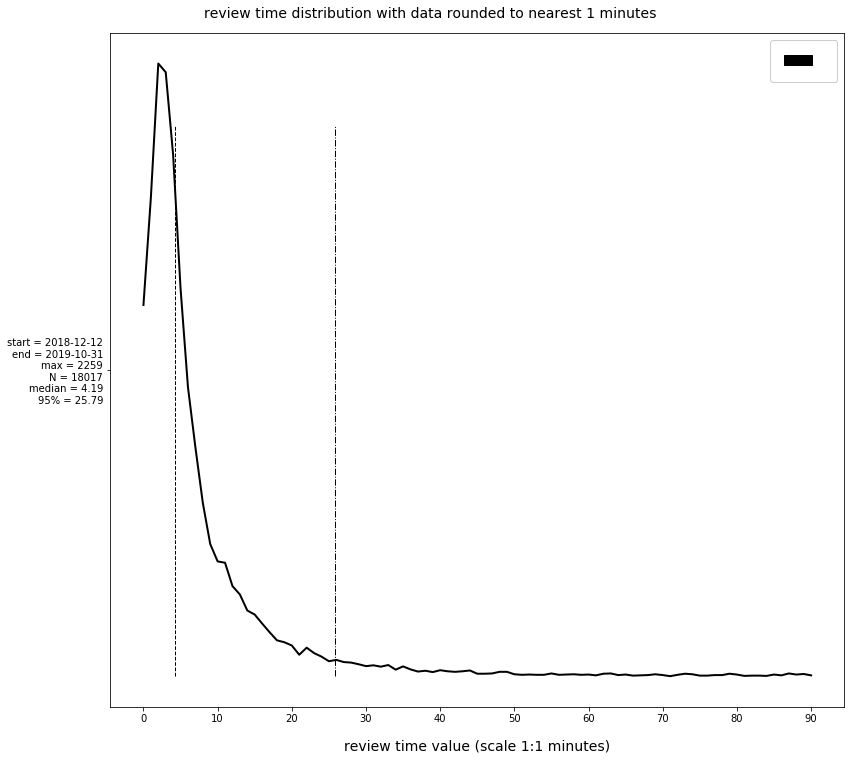


start time of time window, time window length, number of events, median event review time
2018-12-12,1,18017,4.19


In [18]:
# Execute code

parsedData = parseData(csv_filename)

data = trimDataByTime(parsedData, time_range[0], time_range[1])

manual, manualMag, automatic = returnDataFrames(data)

df = returnAnalysisDataFrame(manual, manualMag, automatic)

plot(df, filter_window, boundaries, time_range[0], time_range[1], by_magnitude, 
     rounding_value, time_window, window_overlap, doPlot, doPrint)